# Predict Energy Consumption

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

## Load Data

In [2]:
#load Traning data
df_train=pd.read_csv('/kaggle/input/predictenergyconsumptiondataset/df_train.csv')
df_test=pd.read_csv('/kaggle/input/predictenergyconsumptiondataset/df_test.csv')

In [3]:
df_train.head()
df_test.head()

,date,power_consumption,year,semester,quarter,day_in_week,week_in_year,day_in_year,month
0,4/1/2010,1687.440,2010,1,2,Thu,13,91,4
1,4/2/2010,1648.622,2010,1,2,Fri,14,92,4
2,4/3/2010,1805.278,2010,1,2,Sat,14,93,4
3,4/4/2010,1690.388,2010,1,2,Sun,14,94,4
4,4/5/2010,1118.820,2010,1,2,Mon,14,95,4


## Data Cleaning

Convert the class of the date column from "character" to "Date", and the class of day_in_week column from character to factor for both datasets. Create indicator variables for factor columns

In [4]:
# Check the current data type of the 'date' column
print(df_train['date'].dtype)

object


In [5]:
# Convert 'date' column to datetime
df_train['date'] = pd.to_datetime(df_train['date'], format='%m/%d/%Y')
df_test['date'] = pd.to_datetime(df_test['date'], format='%m/%d/%Y')

In [6]:
# Check the current data type of the 'day_in_week' column
print(df_train['day_in_week'].dtype) 
print(df_test['day_in_week'].dtype) 

# Convert 'day_in_week' column to factor (categorical) type
df_train['day_in_week'] = pd.Categorical(df_train['day_in_week'])
df_test['day_in_week'] = pd.Categorical(df_test['day_in_week'])

object
object


In [7]:
df_train.head()

,date,power_consumption,year,semester,quarter,day_in_week,week_in_year,day_in_year,month
0,2006-12-16,1209.176,2006,2,4,Sat,50,350,12
1,2006-12-17,3390.460,2006,2,4,Sun,51,351,12
2,2006-12-18,2203.826,2006,2,4,Mon,51,352,12
3,2006-12-19,1666.194,2006,2,4,Tue,51,353,12
4,2006-12-20,2225.748,2006,2,4,Wed,51,354,12


In [8]:
df_train_one_hot = pd.get_dummies(df_train, columns=['day_in_week'])
df_test_one_hot = pd.get_dummies(df_test, columns=['day_in_week'])

In [9]:
df_train_one_hot.head()

,date,power_consumption,year,semester,quarter,week_in_year,day_in_year,month,day_in_week_Fri,day_in_week_Mon,day_in_week_Sat,day_in_week_Sun,day_in_week_Thu,day_in_week_Tue,day_in_week_Wed
0,2006-12-16,1209.176,2006,2,4,50,350,12,False,False,True,False,False,False,False
1,2006-12-17,3390.460,2006,2,4,51,351,12,False,False,False,True,False,False,False
2,2006-12-18,2203.826,2006,2,4,51,352,12,False,True,False,False,False,False,False
3,2006-12-19,1666.194,2006,2,4,51,353,12,False,False,False,False,False,True,False
4,2006-12-20,2225.748,2006,2,4,51,354,12,False,False,False,False,False,False,True


In [10]:
df_train_one_hot.shape

(1202, 15)

In [11]:
df_train_one_hot.describe()

,date,power_consumption,year,semester,quarter,week_in_year,day_in_year,month
count,1202,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000
mean,2008-08-07 12:00:00,1592.959253,2008.123128,1.472546,2.415141,25.455907,175.179700,6.256240
min,2006-12-16 00:00:00,0.000000,2006.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2007-10-12 06:00:00,1179.841500,2007.000000,1.000000,1.000000,11.000000,76.000000,3.000000
50%,2008-08-07 12:00:00,1583.971000,2008.000000,1.000000,2.000000,25.000000,171.000000,6.000000
75%,2009-06-03 18:00:00,1952.951500,2009.000000,2.000000,3.000000,39.000000,271.000000,9.000000
max,2010-03-31 00:00:00,4773.386000,2010.000000,2.000000,4.000000,53.000000,366.000000,12.000000
std,NaN,632.497568,0.972467,0.499453,1.153442,15.623968,109.371519,3.573317


In [12]:
df_train_one_hot.isnull().sum()

date                 0
power_consumption    0
year                 0
semester             0
quarter              0
week_in_year         0
day_in_year          0
month                0
day_in_week_Fri      0
day_in_week_Mon      0
day_in_week_Sat      0
day_in_week_Sun      0
day_in_week_Thu      0
day_in_week_Tue      0
day_in_week_Wed      0
dtype: int64

In [13]:
df_test_one_hot.isnull().sum()

date                 0
power_consumption    0
year                 0
semester             0
quarter              0
week_in_year         0
day_in_year          0
month                0
day_in_week_Fri      0
day_in_week_Mon      0
day_in_week_Sat      0
day_in_week_Sun      0
day_in_week_Thu      0
day_in_week_Tue      0
day_in_week_Wed      0
dtype: int64

## Prepare training and testing data for modeling

In [14]:
# Define features and target
X_train = df_train_one_hot.drop(['date', 'power_consumption'], axis=1)
y_train = df_train_one_hot['power_consumption']

X_test = df_train_one_hot.drop(['date', 'power_consumption'], axis=1)
y_test = df_train_one_hot['power_consumption']

X_train

,year,semester,quarter,week_in_year,day_in_year,month,day_in_week_Fri,day_in_week_Mon,day_in_week_Sat,day_in_week_Sun,day_in_week_Thu,day_in_week_Tue,day_in_week_Wed
0,2006,2,4,50,350,12,False,False,True,False,False,False,False
1,2006,2,4,51,351,12,False,False,False,True,False,False,False
2,2006,2,4,51,352,12,False,True,False,False,False,False,False
3,2006,2,4,51,353,12,False,False,False,False,False,True,False
4,2006,2,4,51,354,12,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2010,1,1,13,86,3,False,False,True,False,False,False,False
1198,2010,1,1,13,87,3,False,False,False,True,False,False,False
1199,2010,1,1,13,88,3,False,True,False,False,False,False,False
1200,2010,1,1,13,89,3,False,False,False,False,False,True,False


In [15]:
X_test

,year,semester,quarter,week_in_year,day_in_year,month,day_in_week_Fri,day_in_week_Mon,day_in_week_Sat,day_in_week_Sun,day_in_week_Thu,day_in_week_Tue,day_in_week_Wed
0,2006,2,4,50,350,12,False,False,True,False,False,False,False
1,2006,2,4,51,351,12,False,False,False,True,False,False,False
2,2006,2,4,51,352,12,False,True,False,False,False,False,False
3,2006,2,4,51,353,12,False,False,False,False,False,True,False
4,2006,2,4,51,354,12,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2010,1,1,13,86,3,False,False,True,False,False,False,False
1198,2010,1,1,13,87,3,False,False,False,True,False,False,False
1199,2010,1,1,13,88,3,False,True,False,False,False,False,False
1200,2010,1,1,13,89,3,False,False,False,False,False,True,False


In [16]:
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=30)

## Normalizing the data

In [17]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

## Train the Model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.initializers import glorot_uniform

# Define the model
model = Sequential()

# Add the input layer with specified shape
model.add(Input(shape=(X_train_norm.shape[1],)))

# Add Dense layers with Xavier initialization
model.add(Dense(200, activation='relu', kernel_initializer=glorot_uniform()))
model.add(Dense(100, activation='relu', kernel_initializer=glorot_uniform()))
model.add(Dense(50, activation='relu', kernel_initializer=glorot_uniform()))

# Output layer (typically doesn't require Xavier initialization)
model.add(Dense(1, activation='linear', kernel_initializer=glorot_uniform()))

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 200)                 │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,001 (109.38 KB)

 Trainable params: 28,001 (109.38 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
# Ensure all data types are correct
X_train_norm = X_train_norm.astype(float)
X_val_morm = X_val_norm.astype(float)
X_test_morm = X_test_norm.astype(float)
y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)


In [21]:
history = model.fit(X_train_norm, y_train, epochs=10000, verbose=1, validation_data=(X_val_norm, y_val),batch_size=8)

Epoch 1/10000
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2502321.5000 - mae: 1444.6346 - val_loss: 240491.1094 - val_mae: 356.2631
Epoch 2/10000
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 237755.5469 - mae: 356.6634 - val_loss: 229379.1562 - val_mae: 347.9309
Epoch 3/10000
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 235841.4375 - mae: 347.1852 - val_loss: 225737.9531 - val_mae: 344.8194
Epoch 4/10000
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 213524.6250 - mae: 335.5769 - val_loss: 222681.9531 - val_mae: 341.4730
Epoch 5/10000
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 249609.7344 - mae: 365.1170 - val_loss: 221760.9688 - val_mae: 341.3161
Epoch 6/10000
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 225626.9531 - mae: 352.0745 - val_loss: 220100.8750 - val_mae: 340.0910
Epoch 7/10000
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 211645.5156 - mae: 334.4447 - val_loss: 225120.5938 - val_mae: 345.1267
Epoch 8/10000
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1350.1932 - mae: 25.3212 
Mean Absolute Error: 22.05327606201172


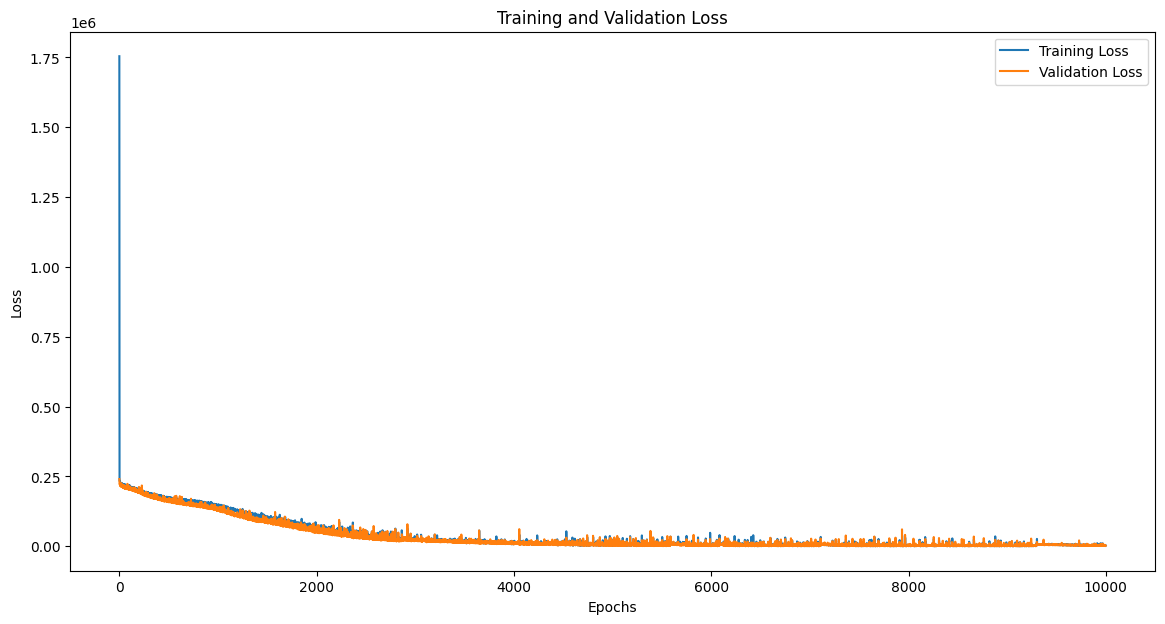

In [22]:
# Evaluate the model
loss, mae = model.evaluate(X_test_norm, y_test)
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [23]:
# Predict the Concrete Compressive Strength for the test dataset 
y_pred = model.predict(X_test_norm)


# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# R-squared
r2 = r2_score(y_test, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [24]:
r2

0.9974232127933156

In [25]:
model.save('Predict_Energy_Consumption_model_1.6.h5')